In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import joblib
import json
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Config

In [2]:
# Base
random_state = 42

# Data
target_raw = '/Users/eugeny/Downloads/data-4/target.feather'
user_features_raw = '/Users/eugeny/Downloads/data-4/user_features.feather'

# Features
categories = ['feature_17', 'feature_21', 'feature_11', 'feature_16', 'feature_22']  
features_path = '../data/processed/features.feather'

# Train
top_K_coef = 0.05 # Считаем метрики для ТОП 5% 
model_path = '../models/model.joblib'
train_metrics = '../reports/train_metrics.json'

# Create features

## Load data

In [3]:
target_df = pd.read_feather(target_raw)
target_df.head()

user_id      month  target
0        0 2020-04-30     1.0
1        0 2020-05-31     0.0
2        0 2020-06-30     1.0
3        0 2020-07-31     0.0
4        0 2020-08-31     1.0

In [4]:
target_df.month.astype(str).unique()

array(['2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
       '2020-08-31'], dtype=object)

In [5]:
target_df.target.value_counts()

0.0    458874
1.0    293254
Name: target, dtype: int64

In [6]:
target_df.month.value_counts()

2020-08-31    150554
2020-07-31    150492
2020-04-30    150484
2020-05-31    150411
2020-06-30    150187
Name: month, dtype: int64

In [7]:
user_features_df = pd.read_feather(user_features_raw)
user_features_df = user_features_df.loc[user_features_df.user_id.isin(target_df.user_id),]
user_features_df.head()

user_id      month  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0 2020-04-30   0.993121        -15   2.274309         18       2868   
1        0 2020-05-31  -1.416912       -145  -1.087891         -8      -1763   
2        0 2020-06-30   0.673564         23   0.016666         -7      -4092   
3        0 2020-07-31  -2.124908        -15   1.234815         18       9348   
4        0 2020-08-31  -2.122264        -50  -0.584464         -8       1894   

   feature_6  feature_7  feature_8  ...          feature_21  \
0  -1.305588  -0.097643   0.617778  ...       H4V75OQHSRBLA   
1  -1.322007   3.143865  -0.272231  ...  AUEOMIKY5CRWBNWO7S   
2  -0.936663  -1.909813   0.715618  ...     4VPOKVAQSMMTDZQ   
3   0.233297  -0.108647  -1.831460  ...      RAGXKIMJHFFGKA   
4  -0.092315  -0.547480  -0.065323  ...      RAGXKIMJHFFGKA   

            feature_22 feature_23  feature_24  feature_25  feature_26  \
0       AOKOISPPQLWGKK  -3.146305   -1.655508          25    3.032537   
1     OORLO7PMHCZFEMSR   2.365636   -2.632201         -11   -2.373654   
2   NZFU27MWLPZRTX4G5D  -2.220931    1.930994         -10    3.301401   
3  KQBIGTVRDJZJLQRRPPY   1.641780   -5.166544         -23    0.531913   
4  KQBIGTVRDJZJLQRRPPY   1.852084   -0.761511         -24   -1.080867   

   feature_27 feature_28 feature_29  feature_30  
0      -29960  -1.864660  -0.212668   -3.245333  
1     -173398   0.458990   1.376687   -0.460150  
2      -46619   0.269820   0.900846    0.315063  
3     -131224  -0.341103   0.208832    1.869453  
4       68577  -1.328331  -0.681723    0.431699  

[5 rows x 32 columns]

In [8]:
user_features_df.month.value_counts()

2020-08-31    150554
2020-07-31    150492
2020-04-30    150484
2020-05-31    150411
2020-06-30    150187
Name: month, dtype: int64

## Process 'month' column

In [9]:
# Convert 'month' to datetime

target_df['month'] = pd.to_datetime(target_df['month'])
user_features_df['month'] = pd.to_datetime(user_features_df['month'])

In [10]:
target_df.head()

user_id      month  target
0        0 2020-04-30     1.0
1        0 2020-05-31     0.0
2        0 2020-06-30     1.0
3        0 2020-07-31     0.0
4        0 2020-08-31     1.0

In [11]:
features = user_features_df.copy()
features.head()

user_id      month  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0 2020-04-30   0.993121        -15   2.274309         18       2868   
1        0 2020-05-31  -1.416912       -145  -1.087891         -8      -1763   
2        0 2020-06-30   0.673564         23   0.016666         -7      -4092   
3        0 2020-07-31  -2.124908        -15   1.234815         18       9348   
4        0 2020-08-31  -2.122264        -50  -0.584464         -8       1894   

   feature_6  feature_7  feature_8  ...          feature_21  \
0  -1.305588  -0.097643   0.617778  ...       H4V75OQHSRBLA   
1  -1.322007   3.143865  -0.272231  ...  AUEOMIKY5CRWBNWO7S   
2  -0.936663  -1.909813   0.715618  ...     4VPOKVAQSMMTDZQ   
3   0.233297  -0.108647  -1.831460  ...      RAGXKIMJHFFGKA   
4  -0.092315  -0.547480  -0.065323  ...      RAGXKIMJHFFGKA   

            feature_22 feature_23  feature_24  feature_25  feature_26  \
0       AOKOISPPQLWGKK  -3.146305   -1.655508          25    3.032537   
1     OORLO7PMHCZFEMSR   2.365636   -2.632201         -11   -2.373654   
2   NZFU27MWLPZRTX4G5D  -2.220931    1.930994         -10    3.301401   
3  KQBIGTVRDJZJLQRRPPY   1.641780   -5.166544         -23    0.531913   
4  KQBIGTVRDJZJLQRRPPY   1.852084   -0.761511         -24   -1.080867   

   feature_27 feature_28 feature_29  feature_30  
0      -29960  -1.864660  -0.212668   -3.245333  
1     -173398   0.458990   1.376687   -0.460150  
2      -46619   0.269820   0.900846    0.315063  
3     -131224  -0.341103   0.208832    1.869453  
4       68577  -1.328331  -0.681723    0.431699  

[5 rows x 32 columns]

In [12]:
# features.sort_values(by=['month']).tail()

## Add target column

In [13]:
%%time

features = pd.merge(
        left=features,
        right=target_df,
        how='left',
        on=['user_id', 'month']
)


features.head()

CPU times: user 470 ms, sys: 194 ms, total: 664 ms
Wall time: 805 ms


user_id      month  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0 2020-04-30   0.993121        -15   2.274309         18       2868   
1        0 2020-05-31  -1.416912       -145  -1.087891         -8      -1763   
2        0 2020-06-30   0.673564         23   0.016666         -7      -4092   
3        0 2020-07-31  -2.124908        -15   1.234815         18       9348   
4        0 2020-08-31  -2.122264        -50  -0.584464         -8       1894   

   feature_6  feature_7  feature_8  ...           feature_22  feature_23  \
0  -1.305588  -0.097643   0.617778  ...       AOKOISPPQLWGKK   -3.146305   
1  -1.322007   3.143865  -0.272231  ...     OORLO7PMHCZFEMSR    2.365636   
2  -0.936663  -1.909813   0.715618  ...   NZFU27MWLPZRTX4G5D   -2.220931   
3   0.233297  -0.108647  -1.831460  ...  KQBIGTVRDJZJLQRRPPY    1.641780   
4  -0.092315  -0.547480  -0.065323  ...  KQBIGTVRDJZJLQRRPPY    1.852084   

  feature_24  feature_25  feature_26  feature_27  feature_28 feature_29  \
0  -1.655508          25    3.032537      -29960   -1.864660  -0.212668   
1  -2.632201         -11   -2.373654     -173398    0.458990   1.376687   
2   1.930994         -10    3.301401      -46619    0.269820   0.900846   
3  -5.166544         -23    0.531913     -131224   -0.341103   0.208832   
4  -0.761511         -24   -1.080867       68577   -1.328331  -0.681723   

  feature_30  target  
0  -3.245333     1.0  
1  -0.460150     0.0  
2   0.315063     1.0  
3   1.869453     0.0  
4   0.431699     1.0  

[5 rows x 33 columns]

In [14]:
features['target'].value_counts(dropna=False)

0.0    458874
1.0    293254
Name: target, dtype: int64

In [15]:
features.shape

(752128, 33)

In [19]:
target_df

user_id      month  target
0             0 2020-04-30     1.0
1             0 2020-05-31     0.0
2             0 2020-06-30     1.0
3             0 2020-07-31     0.0
4             0 2020-08-31     1.0
...         ...        ...     ...
752123   223844 2020-06-30     0.0
752124   223844 2020-08-31     0.0
752125   223845 2020-04-30     1.0
752126   223845 2020-05-31     1.0
752127   223845 2020-06-30     0.0

[752128 rows x 3 columns]

In [16]:
(
    user_features_df
    .merge(target_df[target_df.target == 1], 
           how="left", 
           on=["user_id", "month"])
    .fillna({"target": 0})
    .groupby("user_id")
    .agg({"target": "sum"})
    .value_counts()
    .sort_index()
)

target
0.0       49354
1.0       86519
2.0       61592
3.0       22215
4.0        3924
5.0         242
dtype: int64

## Process nulls 

In [17]:
# Заполняем  NaN target 0 

features.dropna(inplace=True)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752128 entries, 0 to 752127
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     752128 non-null  int64         
 1   month       752128 non-null  datetime64[ns]
 2   feature_1   752128 non-null  float64       
 3   feature_2   752128 non-null  int32         
 4   feature_3   752128 non-null  float64       
 5   feature_4   752128 non-null  int32         
 6   feature_5   752128 non-null  int32         
 7   feature_6   752128 non-null  float64       
 8   feature_7   752128 non-null  float64       
 9   feature_8   752128 non-null  float64       
 10  feature_9   752128 non-null  float64       
 11  feature_10  752128 non-null  float64       
 12  feature_11  752128 non-null  category      
 13  feature_12  752128 non-null  float64       
 14  feature_13  752128 non-null  float64       
 15  feature_14  752128 non-null  float64       
 16  fe

## Save features

In [36]:
features.to_feather(features_path)

In [37]:
!ls data/processed/

features.feather


# Split data

Example for reference: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8 

In [38]:
from pandas.tseries.offsets import MonthEnd

def custom_ts_split(months, train_period = 0):
    
    for k, month in enumerate(months):
        
    
        start_train = pd.to_datetime(months.min())
        end_train = pd.to_datetime(start_train) + MonthEnd(train_period - 1 + k)

        test_period = pd.to_datetime(end_train + MonthEnd(1))
        
        if test_period <= pd.to_datetime(months.max()):
            
            yield start_train, end_train, test_period
            
        else: 
            print(test_period)
            print(months.max())

In [39]:
# print months 

months = features.month.sort_values().unique()
months

array(['2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [40]:
# test custom_ts_split function - iterate over splits 
k = 1
for start_train, end_train, test_period in custom_ts_split(months, train_period = 1):
        print(f'Fold {k}:')    
        print(f'Train: {start_train} - {end_train}')
        print(f'Test: {test_period} \n')
        k+=1

Fold 1:
Train: 2020-04-30 00:00:00 - 2020-04-30 00:00:00
Test: 2020-05-31 00:00:00 

Fold 2:
Train: 2020-04-30 00:00:00 - 2020-05-31 00:00:00
Test: 2020-06-30 00:00:00 

Fold 3:
Train: 2020-04-30 00:00:00 - 2020-06-30 00:00:00
Test: 2020-07-31 00:00:00 

Fold 4:
Train: 2020-04-30 00:00:00 - 2020-07-31 00:00:00
Test: 2020-08-31 00:00:00 

2020-09-30 00:00:00
2020-08-31T00:00:00.000000000


# Train

## Metrics

In [41]:
def plot_Lift_curve(y_true, y_pred, step=0.01):
    """
    # Function that plots a Lift Curve using the real label values of a dataset and the probability predictions of a Machine Learning Algorithm/model
    # @Params:
    # y_val: real labels of the data
    # y_pred: probability predictions for such data
    # step: how big we want the steps in the percentiles to be
    
    Reference: https://towardsdatascience.com/the-lift-curve-unveiled-998851147871
    """
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_true
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()
    

In [42]:
def precision_at_k_score(actual, predicted, predicted_probas, k) -> float:
    
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'probas': predicted_probas})
    df = df.sort_values(by=['probas'], ascending=False).reset_index(drop=True)
    df = df[:k]

    return precision_score(df['actual'], df['predicted'])

### Recall @k

In [43]:
def recall_at_k_score(actual, predicted, predicted_probas,  k) -> float:

    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'probas': predicted_probas})
    df = df.sort_values(by=['probas'], ascending=False).reset_index(drop=True)
    df = df[:k]

    return recall_score(df['actual'], df['predicted'])


### Lift @K

In [44]:
def lift_score(actual, predicted, predicted_probas,  k) -> float:
 
    numerator = precision_at_k_score(actual, predicted, predicted_probas,  k)
    denominator = np.mean(actual)

    lift = numerator / denominator

    print(f'Lift: {numerator} / {denominator} = {lift}')

    return  lift

## Load data 

In [45]:
features = pd.read_feather(features_path)

# format data
features['month'] = pd.to_datetime(features['month'])
features.head()

user_id      month  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0 2020-04-30   0.993121        -15   2.274309         18       2868   
1        0 2020-05-31  -1.416912       -145  -1.087891         -8      -1763   
2        0 2020-06-30   0.673564         23   0.016666         -7      -4092   
3        0 2020-07-31  -2.124908        -15   1.234815         18       9348   
4        0 2020-08-31  -2.122264        -50  -0.584464         -8       1894   

   feature_6  feature_7  feature_8  ...           feature_22  feature_23  \
0  -1.305588  -0.097643   0.617778  ...       AOKOISPPQLWGKK   -3.146305   
1  -1.322007   3.143865  -0.272231  ...     OORLO7PMHCZFEMSR    2.365636   
2  -0.936663  -1.909813   0.715618  ...   NZFU27MWLPZRTX4G5D   -2.220931   
3   0.233297  -0.108647  -1.831460  ...  KQBIGTVRDJZJLQRRPPY    1.641780   
4  -0.092315  -0.547480  -0.065323  ...  KQBIGTVRDJZJLQRRPPY    1.852084   

  feature_24  feature_25  feature_26  feature_27  feature_28 feature_29  \
0  -1.655508          25    3.032537      -29960   -1.864660  -0.212668   
1  -2.632201         -11   -2.373654     -173398    0.458990   1.376687   
2   1.930994         -10    3.301401      -46619    0.269820   0.900846   
3  -5.166544         -23    0.531913     -131224   -0.341103   0.208832   
4  -0.761511         -24   -1.080867       68577   -1.328331  -0.681723   

  feature_30  target  
0  -3.245333     1.0  
1  -0.460150     0.0  
2   0.315063     1.0  
3   1.869453     0.0  
4   0.431699     1.0  

[5 rows x 33 columns]

In [46]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752128 entries, 0 to 752127
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     752128 non-null  int64         
 1   month       752128 non-null  datetime64[ns]
 2   feature_1   752128 non-null  float64       
 3   feature_2   752128 non-null  int32         
 4   feature_3   752128 non-null  float64       
 5   feature_4   752128 non-null  int32         
 6   feature_5   752128 non-null  int32         
 7   feature_6   752128 non-null  float64       
 8   feature_7   752128 non-null  float64       
 9   feature_8   752128 non-null  float64       
 10  feature_9   752128 non-null  float64       
 11  feature_10  752128 non-null  float64       
 12  feature_11  752128 non-null  category      
 13  feature_12  752128 non-null  float64       
 14  feature_13  752128 non-null  float64       
 15  feature_14  752128 non-null  float64       
 16  fe

## Fit

In [59]:
import catboost as ctb

clf = ctb.CatBoostClassifier(
    iterations=10, 
    thread_count=50, 
    has_time=True, 
    allow_writing_files=False,
    cat_features=categories,
    loss_function="Logloss",
)

top_K is 5.0 % of dataset_size: 37606
Fold 1:
Train: 2020-04-30 00:00:00 - 2020-04-30 00:00:00
Test: 2020-05-31 00:00:00 

Train shapes: X - (150484, 30), y - (150484,)
Test shapes: X - (150411, 30), y - (150411,)
Learning rate set to 0.5
0:	total: 119ms	remaining: 1.07s
1:	total: 246ms	remaining: 986ms
2:	total: 369ms	remaining: 862ms
3:	total: 502ms	remaining: 753ms
4:	total: 613ms	remaining: 613ms
5:	total: 743ms	remaining: 495ms
6:	total: 877ms	remaining: 376ms
7:	total: 995ms	remaining: 249ms
8:	total: 1.13s	remaining: 125ms
9:	total: 1.25s	remaining: 0us
Max probas: 0.9748887441234043
Lift: 0.8227676434611498 / 0.39038368204453133 = 2.1075871797512686
Precision at 37606: 0.8227676434611498
Recall at 37606: 1.0


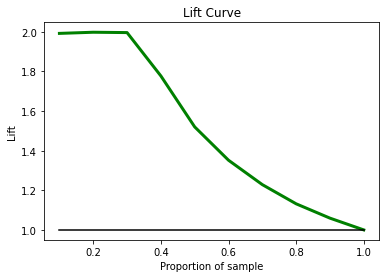



Fold 2:
Train: 2020-04-30 00:00:00 - 2020-05-31 00:00:00
Test: 2020-06-30 00:00:00 

Train shapes: X - (300895, 30), y - (300895,)
Test shapes: X - (150187, 30), y - (150187,)
Learning rate set to 0.5
0:	total: 159ms	remaining: 1.43s
1:	total: 292ms	remaining: 1.17s
2:	total: 421ms	remaining: 982ms
3:	total: 581ms	remaining: 872ms
4:	total: 722ms	remaining: 722ms
5:	total: 867ms	remaining: 578ms
6:	total: 1.02s	remaining: 436ms
7:	total: 1.17s	remaining: 292ms
8:	total: 1.3s	remaining: 144ms
9:	total: 1.44s	remaining: 0us
Max probas: 0.9728085269755247
Lift: 0.8294155188001915 / 0.38953438047234445 = 2.129248560279718
Precision at 37606: 0.8294155188001915
Recall at 37606: 1.0


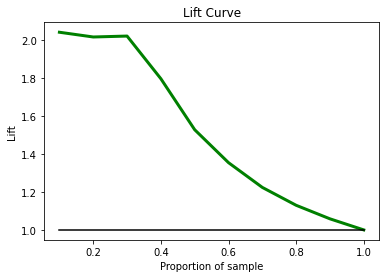



Fold 3:
Train: 2020-04-30 00:00:00 - 2020-06-30 00:00:00
Test: 2020-07-31 00:00:00 

Train shapes: X - (451082, 30), y - (451082,)
Test shapes: X - (150492, 30), y - (150492,)
Learning rate set to 0.5
0:	total: 203ms	remaining: 1.83s
1:	total: 367ms	remaining: 1.47s
2:	total: 541ms	remaining: 1.26s
3:	total: 699ms	remaining: 1.05s
4:	total: 868ms	remaining: 868ms
5:	total: 1.07s	remaining: 716ms
6:	total: 1.31s	remaining: 563ms
7:	total: 1.5s	remaining: 375ms
8:	total: 1.67s	remaining: 186ms
9:	total: 1.85s	remaining: 0us
Max probas: 0.971647421673504
Lift: 0.8193373397862044 / 0.38920341280599635 = 2.1051648388155684
Precision at 37606: 0.8193373397862044
Recall at 37606: 1.0


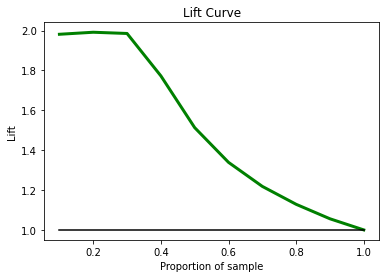



Fold 4:
Train: 2020-04-30 00:00:00 - 2020-07-31 00:00:00
Test: 2020-08-31 00:00:00 

Train shapes: X - (601574, 30), y - (601574,)
Test shapes: X - (150554, 30), y - (150554,)
Learning rate set to 0.5
0:	total: 237ms	remaining: 2.14s
1:	total: 420ms	remaining: 1.68s
2:	total: 612ms	remaining: 1.43s
3:	total: 790ms	remaining: 1.19s
4:	total: 979ms	remaining: 979ms
5:	total: 1.16s	remaining: 774ms
6:	total: 1.39s	remaining: 596ms
7:	total: 1.58s	remaining: 394ms
8:	total: 1.78s	remaining: 198ms
9:	total: 2s	remaining: 0us
Max probas: 0.9663046597886773
Lift: 0.8225549114503005 / 0.39068374138182976 = 2.105423963999533
Precision at 37606: 0.8225549114503005
Recall at 37606: 1.0


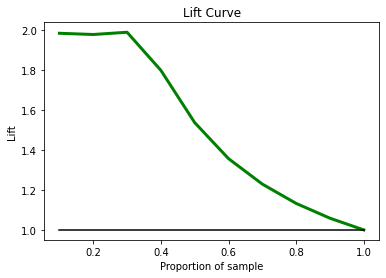



2020-09-30 00:00:00
2020-08-31T00:00:00.000000000


In [60]:
"""Fit / evaluate estimator for each split

params from config: 
    - top_K

"""

# DF to store metrics for each fold
metrics_df = pd.DataFrame(columns=['test_period', 'lift', 'precision_at_k', 'recall_at_k'])
top_K = int(features.shape[0] * top_K_coef)
print(f'top_K is 5.0 % of dataset_size: {top_K}')

k = 1
for start_train, end_train, test_period in custom_ts_split(months, train_period = 1):
    
    print(f'Fold {k}:')    
    print(f'Train: {start_train} - {end_train}')
    print(f'Test: {test_period} \n')

    # Get train / test data for the split
    X_train = (features[(features.month >= start_train) & (features.month <= end_train)]
               .drop(columns=['user_id', 'month', 'target'], axis=1))
    X_test = (features[(features.month == test_period)]
              .drop(columns=['user_id', 'month', 'target'], axis=1))
    y_train = features.loc[(features.month >= start_train) & (features.month <= end_train), 'target']
    y_test = features.loc[(features.month == test_period), 'target']

    print(f'Train shapes: X - {X_train.shape}, y - {y_train.shape}')
    print(f'Test shapes: X - {X_test.shape}, y - {y_test.shape}')
    
    # Fit estimator
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    probas = clf.predict_proba(X_test)
    print(f'Max probas: {probas[:, 1].max()}')
    
    lift = lift_score(y_test, y_pred, probas[:, 1], top_K)
    precision_at_k = precision_at_k_score(y_test, y_pred, probas[:, 1], top_K)
    recall_at_k = recall_at_k_score(y_test, y_pred, probas[:, 1], top_K)
    
    metrics_df = metrics_df.append(
        dict(zip(metrics_df.columns, [test_period, lift, precision_at_k, recall_at_k])),
        ignore_index=True
    )

    k+=1
    
    print(f'Precision at {top_K}: {precision_at_k}')
    print(f'Recall at {top_K}: {recall_at_k}')
    plot_Lift_curve(y_test[:top_K], y_pred[:top_K], step=0.1)
    print('\n')

In [53]:
metrics_df

test_period      lift  precision_at_k  recall_at_k
0  2020-05-31  2.107587        0.822768          1.0
1  2020-06-30  2.129249        0.829416          1.0
2  2020-07-31  2.105165        0.819337          1.0
3  2020-08-31  2.105424        0.822555          1.0

In [50]:
metrics_aggs = metrics_df[['lift', 'precision_at_k', 'recall_at_k']].agg(['max', 'min', 'std', 'mean'])
metrics = {
    f'{metric}_{agg}': metrics_aggs.loc[agg, metric]
    for metric in metrics_aggs.columns
    for agg in metrics_aggs.index
}

with open(train_metrics, 'w') as metrics_f:
    json.dump(obj=metrics, fp=metrics_f, indent=4)

metrics_aggs

lift  precision_at_k  recall_at_k
max   2.129249        0.829416          1.0
min   2.105165        0.819337          1.0
std   0.011646        0.004233          0.0
mean  2.111856        0.823519          1.0

### Save model

In [51]:
joblib.dump(clf, model_path)

['../models/model.joblib']